In [ ]:
!pip install torch
!pip install scipy 
!pip install torchmetrics
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
from PIL import Image
import random
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import pickle
from sklearn import manifold
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
import scipy.io
from google.colab import drive
drive.mount("/content/gdrive",force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os
from time import time
from tqdm import tqdm
import numpy

import torch
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from torchvision.transforms import transforms

In [ ]:
import wandb
wandb.login(key="1262a78bcdb91721d1f31364cec1d26409dd981e")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## PART 1

In [ ]:
import glob
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data = scipy.io.loadmat("/content/gdrive/MyDrive/cv1.mat")

data_size = len(data['y'])
# data_size = 20000
data['y'][ data['y'] == 10 ] = 0


transform = transforms.Compose(
    
    [   
        transforms.ToTensor(),
        # transforms.Resize((32,32)),
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

     ])

import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, data ,transform=None, target_transform=None):
        self.img_labels = data['y']
        self.img_dir = data['X']
        self.transform = transform
        self.data = data

        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = self.img_dir[:,:,:,idx]
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
            # image = image.to(device)
        if self.target_transform:
            label = self.target_transform(label)
        # print(idx)
        return image, label


# shuffle
indices = list(range(data_size))
np.random.shuffle(indices)

test_size =  int(  0.10*data_size )
val_size =   int(  0.20*data_size )
train_size = int(  0.70*data_size )

test_index = indices[:test_size]
train_index = indices[test_size:test_size+train_size]
val_index = indices[-val_size:]

g = torch.Generator()
g.manual_seed(42)
batch_size = 64

train_sampler=SubsetRandomSampler(train_index, generator=g)
val_sampler=SubsetRandomSampler(val_index, generator=g)
test_sampler=SubsetRandomSampler(test_index, generator=g)

xt = data['X'][:train_size]
yt = data['y'][:train_size]
data_train = {'X':xt,'y':yt}

xt = data['X'][:test_size]
yt = data['y'][:test_size]
data_test = {'X':xt,'y':yt}

xt = data['X'][-val_size:]
yt = data['y'][-val_size:]
data_val = {'X':xt,'y':yt}

In [ ]:
# x = np.arange(1,10)
# p = np.array([1,2,3])
# x[p]

In [ ]:
# for i in range(test_size,-val_size+data_size):
#   if(data['X'][:,:,:,i].shape!=((32, 32, 3))):
#     print("yo!!")
#     break


In [ ]:
# train = CustomImageDataset(data_train,transform)
# test =  CustomImageDataset(data_test,transform)
# val =  CustomImageDataset(data_val,transform)

final_dataset = CustomImageDataset(data,transform)

trainloader = torch.utils.data.DataLoader(final_dataset, sampler = train_sampler, batch_size=batch_size,num_workers=2)
valloader = torch.utils.data.DataLoader(final_dataset, sampler = val_sampler, batch_size=batch_size,num_workers=2)
testloader = torch.utils.data.DataLoader(final_dataset, sampler = test_sampler, batch_size=batch_size,num_workers=2)

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.__next__()

In [ ]:
print(images.shape)

torch.Size([64, 3, 32, 32])


tensor([7], dtype=torch.uint8)


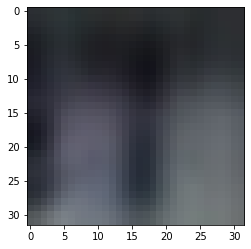

In [ ]:
idx = 8
plt.imshow(images[idx].permute(1,2,0))
print(labels[idx])

In [ ]:
y_train = []
y_val = []

for idx in train_index:
  # print(type(idx))
  if(data['y'][idx] == 0):
      y_train.append(10)
  else:
      y_train.append(data['y'][idx])

for idx in val_index:
    if(data['y'][idx] == 0):
        y_val.append(10)
    else:
        y_val.append(data['y'][idx])

print(len(y_train)) 
print(len(y_val))

51279
14651


<ipython-input-53-9ec1fc2a3a59>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_train = np.array(y_train)
<ipython-input-53-9ec1fc2a3a59>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y_val = np.array(y_val)


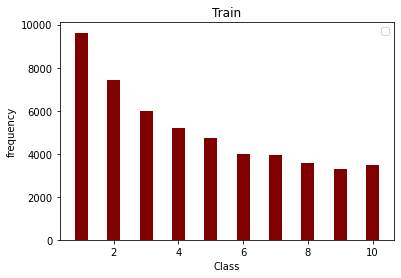

In [ ]:
y_train = np.array(y_train)
y_val = np.array(y_val)

# visualizing
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts, color ='maroon',
        width = 0.4)
plt.title("Train")

plt.xlabel("Class")
plt.ylabel("frequency")
plt.legend()

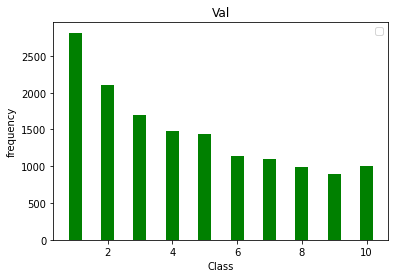

In [ ]:
unique, counts = np.unique(y_val, return_counts=True)
plt.bar(unique, counts, color ='green',
        width = 0.4)
plt.title("Val")

plt.xlabel("Class")
plt.ylabel("frequency")
plt.legend()

## Part 2

In [ ]:
# part (a)
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), padding=1)
        self.relu1 = ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
        self.relu2 = ReLU()
        self.fc1 = nn.Linear(65536, 10)

        # self.relu3 = ReLU()
        # self.fc2 = nn.Linear(128, 10)
        # self.logSoftmax = LogSoftmax(dim=1)
      
    def forward(self,x):
        x = self.relu1((self.conv1(x)))
        x = self.relu2((self.conv2(x)))
        # x = relu2((self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        # x = self.relu3(self.fc1(x))
        x = self.fc1(x)
        # output = self.logSoftmax(x)
        return x



In [ ]:
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

model = CNN()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.001)
criterion =  nn.CrossEntropyLoss()
# checking if GPU is available
model = model.to(device)
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (fc1): Linear(in_features=65536, out_features=10, bias=True)
)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="Q1",
)
## command to log gradients to wandb
wandb.watch(model)  ## pass name of model for which we want to log gradients, helps for analysis


total_loss_train = []
total_loss_validation = []


## command to log gradients to wandb
# wandb.watch(model)  ## pass name of model for which we want to log gradients, helps for analysis
epochs = 10
for epoch in range(epochs):  
    # print(epoch + 1)
    
    batch_loss_train=0
    batch_loss_val=0

    num_batches = 0
    correct = 0
    total = 0
    cnt=0
    for i, data in enumerate(trainloader, 0):
        


        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.reshape((len(labels),))
       
        total += labels.size(0)
        cnt+=1

        train_pred = torch.max(outputs, 1).indices
        correct += int(torch.sum(train_pred == labels))
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_loss_train+=loss.item()
        running_loss = loss.item()
        # print('[epoch, batch] =  [%d, %5d] loss: %.6f' %(epoch + 1, i, running_loss))
        num_batches+=1
        # print(num_batches)

    batch_loss_train/=num_batches
    acc = 100 * correct / total

    wandb.log(
          {"train accuracy" : acc,"train loss":batch_loss_train}
          )

    print("Trainging Accuracy ",acc)
    print("Trianing Loss ",batch_loss_train)

    total_loss_train.append(batch_loss_train)
    
    # Valdiation Loop
    with torch.no_grad():
      correct = 0
      total = 0
      cnt=0
      # ✨ W&B: parameters
      log_counter = 0
      NUM_BATCHES_TO_LOG = 10
      NUM_IMAGES_PER_BATCH = 64
      i=-1
      for data in valloader:
          i+=1
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          # Get Prediction
          outputs = model(inputs)

          # Compute loss 
          total += labels.size(0)
          cnt+=1
          #labels = labels.float()
          labels = labels.reshape((len(labels),))
          
          #print(outputs.shape)
          loss_val = criterion(outputs, labels)
          batch_loss_val += loss_val.item()
          

          out_cpu = outputs.cpu()
          predicted = [np.argmax(x) for x in out_cpu]
          predicted = torch.Tensor(predicted).to(device)
          correct += (predicted == labels).sum().item()

  
      acc = 100 * correct / total
      total_loss_validation += [batch_loss_val/cnt]
      #W&B: Log accuracy across training epochs, to visualize in the UI
     

      print("Validation loss is ",batch_loss_val/cnt)
      print("Validation Acc is ", acc)

      wandb.log(
          {"val accuracy" :acc ,"val loss":batch_loss_val/cnt}
          )

print('Finished Training')

Trainging Accuracy  44.68885898710973
Trianing Loss  1.661302262410856
Validation loss is  1.0196425834076894
Validation Acc is  68.99187768752986
Trainging Accuracy  76.9398779227364
Trianing Loss  0.775113595579925
Validation loss is  0.6584371346573642
Validation Acc is  81.15486997474575
Trainging Accuracy  83.49811813802921
Trianing Loss  0.5744765225119721
Validation loss is  0.5841329142646497
Validation Acc is  83.5233089891475
Trainging Accuracy  85.5886425242302
Trianing Loss  0.5014002423482643
Validation loss is  0.5615474331847445
Validation Acc is  84.40379496280117
Trainging Accuracy  87.00052653132862
Trianing Loss  0.4546729487336782
Validation loss is  0.5659140012019587
Validation Acc is  84.45157327144905
Trainging Accuracy  87.73767039138829
Trianing Loss  0.42323093084697416
Validation loss is  0.5685454843216068
Validation Acc is  84.3218892908334
Trainging Accuracy  88.45726320716082
Trianing Loss  0.3977654669015782
Validation loss is  0.5598507972523635
Valida

In [ ]:
true = torch.tensor([]).to(device)
pred = torch.tensor([]).to(device)
      

from torchmetrics.classification import F1Score
# print(f1_true)
# print(f1_pred)


true_val = torch.tensor([]).to(device)
pred_val = torch.tensor([]).to(device)
ll = 0


missclassified_images = []
missclassified_images_label = []
missclassified_images_pred = []

total_loss_validation = []

with torch.no_grad():
      correct = 0
      total = 0
      cnt=0
      # ✨ W&B: parameters
      log_counter = 0
      NUM_BATCHES_TO_LOG = 10
      NUM_IMAGES_PER_BATCH = 64
      i=-1
      batch_loss_val= 0
      for data in testloader:
          
          i+=1
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          # Get Prediction
          outputs = loaded_model(inputs)

          # Compute loss 
          total += labels.size(0)
          cnt+=1
          #labels = labels.float()
          labels = labels.reshape((len(labels),))
          
          #print(outputs.shape)
          loss_val = criterion(outputs, labels)
          batch_loss_val += loss_val.item()
          

          out_cpu = outputs.cpu()
          predicted = [np.argmax(x) for x in out_cpu]
          predicted = torch.Tensor(predicted).to(device)
          correct += (predicted == labels).sum().item()

          for r in range(len(predicted)):
            if(predicted[r] != labels[r]):
              missclassified_images.append(inputs[r])
              missclassified_images_label.append(labels[r])
              missclassified_images_pred.append(predicted[r])
          true_val = torch.cat((true_val, labels))
          pred_val = torch.cat((pred_val, predicted))

          

          ll+=len(labels)
  
      acc = 100 * correct / total
      total_loss_validation += [batch_loss_val/cnt]

      
      # ✨ W&B: Log accuracy across training epochs, to visualize in the UI
     


f1 = F1Score(task="multiclass", num_classes=10)
print(f1(pred_val.cpu(), true_val.cpu()))
# print(test_accuracy_epoch*100)
print(acc)   

print('Finished Testing...')


tensor(0.8426)
84.25938566552901
Finished Testing...


In [ ]:
# missclassified_images 
# missclassified_images_label 
# missclassified_images = missclassified_images
# missclassified_images_label = missclassified_images_label.to(device)
l = []
for i in range(len(missclassified_images_label)):
  if(missclassified_images_label[i] == 4):
    l.append(i)


# plt.imshow(missclassified_images[0].cpu().permute(1,2,0))
# print(missclassified_images_label[0])

In [ ]:
len(l)

748

tensor(2., device='cuda:0')
tensor(4, device='cuda:0', dtype=torch.uint8)


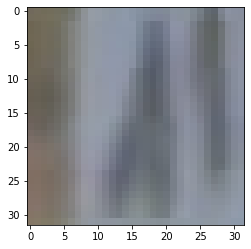

In [ ]:
idx = 611-11-11-20-11-440-110
plt.imshow(missclassified_images[l[idx]].cpu().permute(1,2,0))
print(missclassified_images_pred[l[idx]])
print(missclassified_images_label[l[idx]])

In [ ]:
from torchmetrics.classification import MulticlassConfusionMatrix
metric = MulticlassConfusionMatrix(num_classes=10)
metric(pred_val.cpu(), true_val.cpu())

tensor([[   0,    0,  499,   26,    0,    0,    0,    0,    1,    0],
        [   2,    0, 1356,   28,    0,    0,    0,    0,    0,    0],
        [   1,    0, 1042,   15,    0,    0,    0,    0,    3,    0],
        [   1,    0,  839,   14,    0,    0,    0,    0,    0,    0],
        [   0,    0,  741,    7,    0,    0,    0,    0,    0,    0],
        [   1,    0,  667,   12,    0,    0,    0,    0,    0,    0],
        [   1,    0,  543,   12,    0,    0,    0,    0,    1,    0],
        [   0,    0,  537,   20,    0,    0,    0,    0,    3,    0],
        [   0,    0,  486,   13,    0,    0,    0,    0,    0,    0],
        [   0,    0,  441,   13,    0,    0,    0,    0,    0,    0]])

In [ ]:
# filename = '/content/gdrive/MyDrive/Datasets/cnn.sav'
# pickle.dump(model, open(filename, 'wb'))

In [ ]:
all_labels = [0,1,2,3,4,5,6,7,8,9]
# preds = pred_val.cpu().numpy().astype(int)
# y_true = true_val.cpu().numpy().astype(int)
preds = []
y_true = []
for i in pred_val.cpu():
    preds.append((int(i.item())))
for i in true_val.cpu():
    y_true.append((int(i.item())))

wandb.log({"my_conf_mat_id" : wandb.plot.confusion_matrix( 
            preds=preds, y_true=y_true,
            class_names=all_labels)})

In [ ]:
filename = '/content/gdrive/MyDrive/Datasets/cnn.sav'
loaded_model = pickle.load(open(filename, 'rb'))


## Trash

In [ ]:
#   for epoch in range(1):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data
#         inputs.float()
#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = model(inputs)
#         labels = torch.reshape(labels, (-1,)).long()
#         # print(labels)
#         loss = criterion(outputs, labels)
#         print(loss)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         print(running_loss)

#         # print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
#         if i % 10 == 1999:    # print every 2000 mini-batches
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
#             running_loss = 0.0

# print('Finished Training')

In [ ]:
# # data_size = len(data['X'])
# data_size = 2000

# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# # shuffle
# indices = list(range(data_size))
# np.random.shuffle(indices)

# test_size =  int(  0.10*data_size )
# val_size =   int(  0.20*data_size )
# train_size = int(  0.70*data_size )


# test_index =  indices[:test_size]
# train_index = indices[test_size:test_size+train_size]
# val_index = indices[-val_size:]

# # df_test = torch.tensor(torch.tensor(data['X'][test_index]),torch.tensor(data['y'][test_index]))

# # from torch.utils.data import TensorDataset
# # label = torch.tensor(data['y'],)
# # img_arr = torch.tensor(data['X'])
# # df = TensorDataset(img_arr, label)


# gen = torch.Generator()
# gen.manual_seed(42)

# train_sampler=SubsetRandomSampler(train_index, generator=gen)
# val_sampler=SubsetRandomSampler(val_index, generator=gen)
# test_sampler=SubsetRandomSampler(test_index, generator=gen)

# batch_size = 64
# trainloader = torch.utils.data.DataLoader(df, sampler = train_sampler, batch_size=batch_size,num_workers=2)
# # valloader = torch.utils.data.DataLoader(df, sampler = val_sampler, batch_size=batch_size,num_workers=2)
# # testloader = torch.utils.data.DataLoader(df,sampler = test_sampler, batch_size=batch_size,num_workers=2)

In [ ]:
# training
y_train = data['y'][train_index]
y_val = data['y'][val_index]

<BarContainer object of 10 artists>

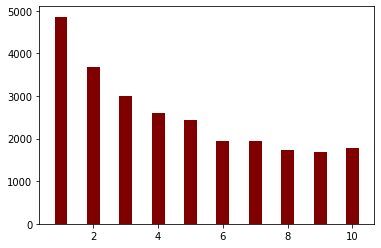

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts, color ='maroon',
        width = 0.4)

<BarContainer object of 10 artists>

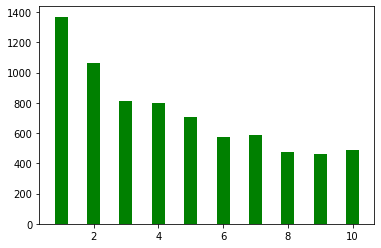

In [ ]:
unique, counts = np.unique(y_val, return_counts=True)
plt.bar(unique, counts, color ='green',
        width = 0.4)

## RESNET

In [ ]:
# https://github.com/shounak8/AIML_Tutotials/blob/master/Deep_Learning/PyTorch/santa_or_not/santa_pytorch_pretrained_model.ipynb

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

In [ ]:
model = resnet18(pretrained=True) # using pre trained resnet
model.fc = Linear(in_features=512, out_features=10)  # changing the dimensions of last output layer to number of classes
model = model.to(device) # using gpu

optimizer = Adam(model.parameters(), lr=0.01) # choosing optimizer and setting cross entropy loss
loss_function = CrossEntropyLoss()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model = resnet18(pretrained=True)   #load resnet18 model
num_features = model.fc.in_features     #extract fc layers features
model.fc = nn.Linear(num_features, 10) #(num_of_class == 10)
model = model.to(device) 
loss_fn = nn.CrossEntropyLoss()  #(set loss function)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="Q1",
# )
## command to log gradients to wandb
# wandb.watch(model)  ## pass name of model for which we want to log gradients, helps for analysis


total_loss_train = []
total_loss_validation = []


## command to log gradients to wandb
# wandb.watch(model)  ## pass name of model for which we want to log gradients, helps for analysis
epochs = 10
for epoch in range(epochs):  
    # print(epoch + 1)
    
    batch_loss_train=0
    batch_loss_val=0

    num_batches = 0
    correct = 0
    total = 0
    cnt=0
    for i, data in enumerate(trainloader, 0):
        


        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.reshape((len(labels),))
       
        total += labels.size(0)
        cnt+=1

        train_pred = torch.max(outputs, 1).indices
        correct += int(torch.sum(train_pred == labels))
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_loss_train+=loss.item()
        running_loss = loss.item()
        # print('[epoch, batch] =  [%d, %5d] loss: %.6f' %(epoch + 1, i, running_loss))
        num_batches+=1
        # print(num_batches)

    batch_loss_train/=num_batches
    acc = 100 * correct / total

    # wandb.log(
    #       {"train accuracy" : acc,"train loss":batch_loss_train}
    #       )

    print("Trainging Accuracy ",acc)
    print("Trianing Loss ",batch_loss_train)

    total_loss_train.append(batch_loss_train)
    
    # Valdiation Loop
    with torch.no_grad():
      correct = 0
      total = 0
      cnt=0
      # ✨ W&B: parameters
      log_counter = 0
      NUM_BATCHES_TO_LOG = 10
      NUM_IMAGES_PER_BATCH = 64
      i=-1
      for data in valloader:
          i+=1
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          # Get Prediction
          outputs = model(inputs)

          # Compute loss 
          total += labels.size(0)
          cnt+=1
          #labels = labels.float()
          labels = labels.reshape((len(labels),))
          
          #print(outputs.shape)
          loss_val = criterion(outputs, labels)
          batch_loss_val += loss_val.item()
          

          out_cpu = outputs.cpu()
          predicted = [np.argmax(x) for x in out_cpu]
          predicted = torch.Tensor(predicted).to(device)
          correct += (predicted == labels).sum().item()

  
      acc = 100 * correct / total
      total_loss_validation += [batch_loss_val/cnt]
      # ✨ W&B: Log accuracy across training epochs, to visualize in the UI
     

      print("Validation loss is ",batch_loss_val/cnt)
      print("Validation Acc is ", acc)

      # wandb.log(
      #     {"val accuracy" :acc ,"val loss":batch_loss_val/cnt}
      #     )

print('Finished Training')

Trainging Accuracy  70.03061682170089
Trianing Loss  0.897367363261463
Validation loss is  0.46343352004690463
Validation Acc is  85.22285168247902
Trainging Accuracy  87.6499151699526
Trianing Loss  0.3961405515893736
Validation loss is  0.3733096649162634
Validation Acc is  88.54003139717426
Trainging Accuracy  90.95926207609352
Trianing Loss  0.2913694442842072
Validation loss is  0.34399487022879865
Validation Acc is  89.53655040611562
Trainging Accuracy  92.65391290781801
Trianing Loss  0.23584068452758236
Validation loss is  0.3391551540993707
Validation Acc is  89.98703160193844
Trainging Accuracy  94.15550225238401
Trianing Loss  0.19158633045870765
Validation loss is  0.34016676048654654
Validation Acc is  90.42386185243328
Trainging Accuracy  95.15786189278262
Trianing Loss  0.15531155912256672
Validation loss is  0.3327016543645786
Validation Acc is  90.71053170432053
Trainging Accuracy  95.92035726125704
Trianing Loss  0.12772416415278268
Validation loss is  0.3447065342982

In [ ]:
# testing
true = torch.tensor([]).to(device)
pred = torch.tensor([]).to(device)


from torchmetrics.classification import F1Score
# print(f1_true)
# print(f1_pred)


true_val = torch.tensor([]).to(device)
pred_val = torch.tensor([]).to(device)
ll = 0
total_loss_validation = []
with torch.no_grad():
      correct = 0
      total = 0
      cnt=0
      # ✨ W&B: parameters
      log_counter = 0
      NUM_BATCHES_TO_LOG = 10
      NUM_IMAGES_PER_BATCH = 64
      i=-1
      batch_loss_val = 0

      for data in testloader:
          i+=1
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          # Get Prediction
          outputs = model(inputs)

          # Compute loss 
          total += labels.size(0)
          cnt+=1
          #labels = labels.float()
          labels = labels.reshape((len(labels),))
          
          #print(outputs.shape)
          loss_val = criterion(outputs, labels)
          batch_loss_val += loss_val.item()
          

          out_cpu = outputs.cpu()
          predicted = [np.argmax(x) for x in out_cpu]
          predicted = torch.Tensor(predicted).to(device)
          correct += (predicted == labels).sum().item()

          true_val = torch.cat((true_val, labels))
          pred_val = torch.cat((pred_val, predicted))

          ll+=len(labels)
  
      acc = 100 * correct / total
      total_loss_validation += [batch_loss_val/cnt]

      
      # ✨ W&B: Log accuracy across training epochs, to visualize in the UI
     


f1 = F1Score(task="multiclass", num_classes=10)
print(f1(pred_val.cpu(), true_val.cpu()))
# print(test_accuracy_epoch*100)
print(acc)      
print('Finished Testing...')

tensor(0.8997)
89.96587030716724
Finished Testing...


In [ ]:
all_labels = [0,1,2,3,4,5,6,7,8,9]
# preds = pred_val.cpu().numpy().astype(int)
# y_true = true_val.cpu().numpy().astype(int)
preds = []
y_true = []
for i in pred_val.cpu():
    preds.append((int(i.item())))
for i in true_val.cpu():
    y_true.append((int(i.item())))

wandb.log({"my_conf_mat_id" : wandb.plot.confusion_matrix( 
            preds=preds, y_true=y_true,
            class_names=all_labels)})

In [ ]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings("ignore")

from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings("ignore")

def construct_TSNE(loader):
  model = resnet18(pretrained=True)
  img = []
  lbl = []

  for i,data in enumerate(loader,0):
      images,labels = data
      labels = labels.numpy()
      output = (model(images)).detach().numpy()

      img.append(output)
      lbl.append(labels)

  
  # img =np.concatenate(img)
  # lbl = np.concatenate(lbl)

  img = np.array(img).flatten()
  lbl = np.array(lbl).flatten()


  tsne = TSNE(n_components=2)
  tsne_transform = tsne.fit_transform(img)

  plt.scatter(tsne_transform[:, 0], tsne_transform[:, 1])
  plt.title('2D t-SNE plot')
  plt.show()  

construct_TSNE(valloader)
construct_TSNE(trainloader)

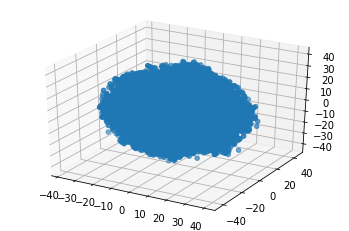

In [ ]:
model = resnet18(pretrained=True)
img = []
lbl = []

for i,data in enumerate(valloader,0):
      images,labels = data
      labels = labels.numpy()
      output = (model(images)).detach().numpy()

      img.append(output)
      lbl.append(labels)


img = np.array(img).flatten()
lbl = np.array(lbl).flatten()      

# img =np.concatenate(img)
# lbl = np.concatenate(lbl)

tsne = TSNE(n_components=3)
val_3d = tsne.fit_transform(img)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(val_3d[:, 0], val_3d[:, 1], val_3d[:, 2])
plt.show()

## Part 4